In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%load_ext tensorboard
!rm -rf './graph/dropout/dropout=0.5,relu/'

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Training image: ', x_train.shape)
print('Testing image: ', x_test.shape)
print('Training label: ', y_train.shape)
print('Testing label: ', y_test.shape)

Training image:  (60000, 28, 28)
Testing image:  (10000, 28, 28)
Training label:  (60000,)
Testing label:  (10000,)


In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [4]:
class SimpleModel(nn.Module):
    def __init__(self, dropout_rate):
        super(SimpleModel, self).__init__()
        self.dense_1 = nn.Linear(28*28, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense_2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dense_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        output = F.log_softmax(self.dense_2(x))
        return output

In [5]:
simple_model = SimpleModel(dropout_rate = 0.5).cuda()

for param in simple_model.parameters():
    if param.requires_grad:
        print('param autograd')
        break
        
input = torch.rand(1, 28, 28).cuda()
output = simple_model(input) 

model_parameters = filter(lambda p: p.requires_grad, simple_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameter:', params)

param autograd
Number of parameter: 101770


In [6]:
from imgaug import augmenters as iaa

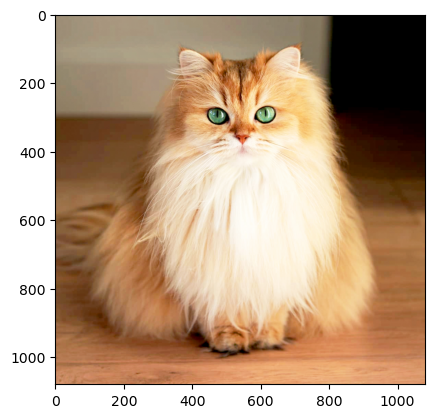

In [7]:
image = cv2.imread('cat.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

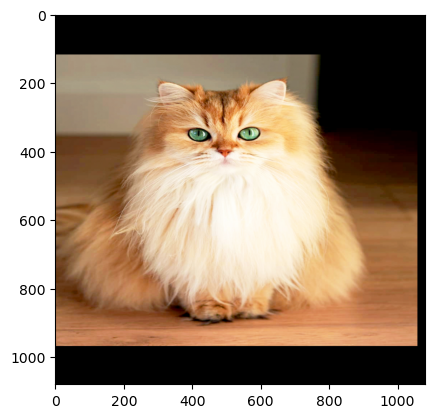

In [8]:
crop_and_pad = iaa.CropAndPad(percent = (-0.25, 0.25))

plt.imshow(cv2.cvtColor(crop_and_pad.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

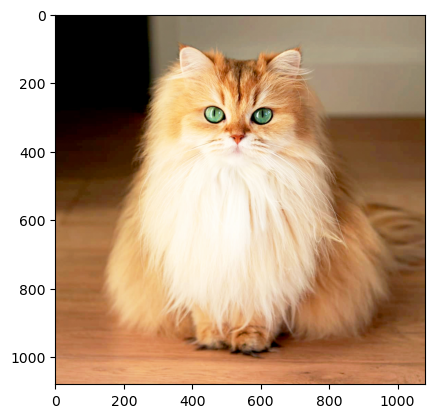

In [9]:
flip_lr = iaa.Fliplr(1)

plt.imshow(cv2.cvtColor(flip_lr.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

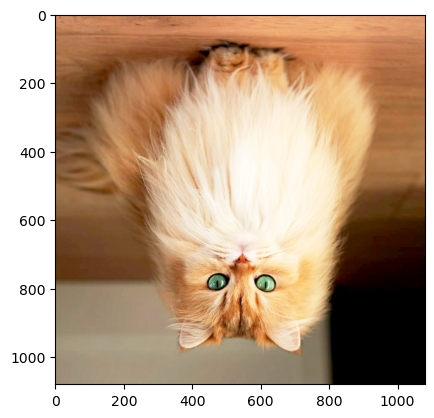

In [10]:
flip_ud = iaa.Flipud(1.0)

plt.imshow(cv2.cvtColor(flip_ud.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

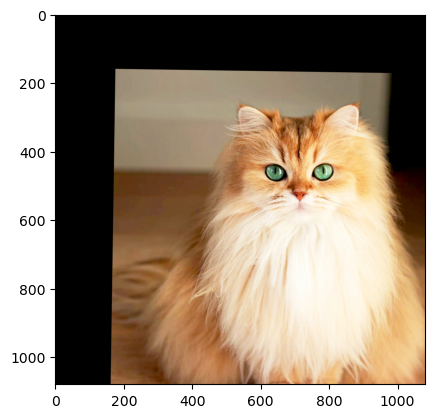

In [11]:
affine = iaa.Affine(scale = (0.5, 1.5), rotate = (-15, 15), translate_percent = (-0.2, 0.2))

plt.imshow(cv2.cvtColor(affine.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

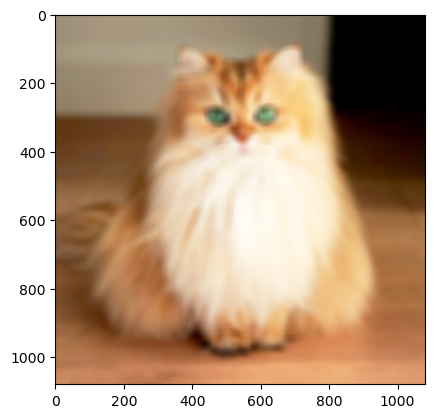

In [12]:
avg_blur = iaa.AverageBlur(k = (11, 31))

plt.imshow(cv2.cvtColor(avg_blur.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

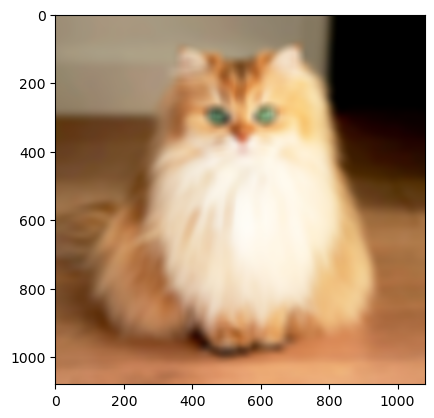

In [13]:
gauu_blur = iaa.GaussianBlur(sigma = (5.0, 15.0))

plt.imshow(cv2.cvtColor(gauu_blur.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

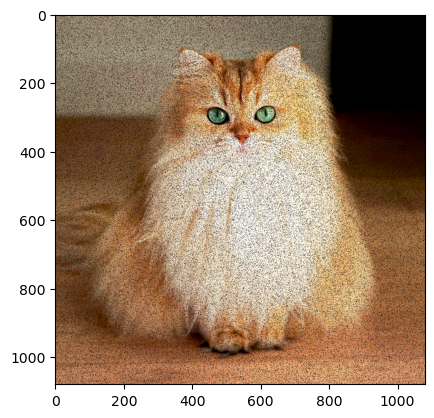

In [14]:
dropout = iaa.Dropout(p = (0, 0.2))

plt.imshow(cv2.cvtColor(dropout.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

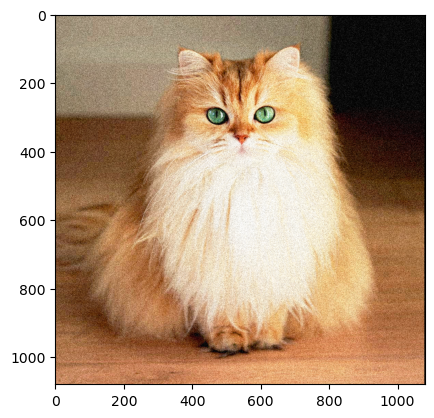

In [15]:
aug = iaa.Sequential([
    iaa.Affine(translate_px = {"x" : (-40, 40)}),
    iaa.AdditiveGaussianNoise(scale = 0.1 * 255)
])

plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

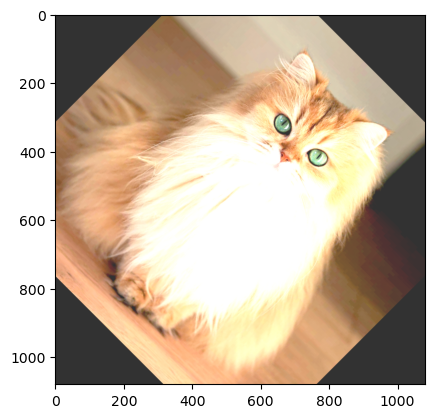

In [28]:
aug = [
    iaa.Affine(rotate = 45),
    iaa.AdditiveGaussianNoise(scale = 0.2 * 255),
    iaa.Add(50, per_channel = True),
    iaa.Sharpen(alpha = 0.5)
]

aug = np.random.choice(aug, 2, replace = False)
aug = iaa.Sequential(aug)

plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

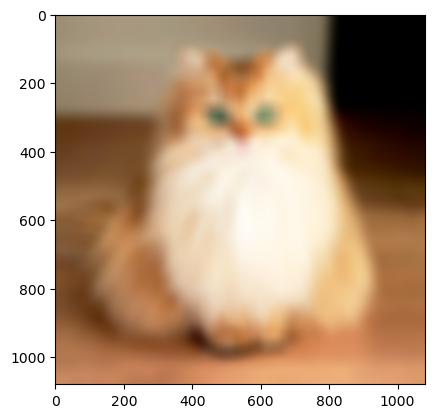

In [35]:
aug = iaa.Sometimes(0.5, iaa.GaussianBlur(sigma = 20.0))

plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
our_aug = iaa.Dropout(p = (0, 0.002))

In [37]:
class Generator(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [38]:
training_data = Generator(x_train, y_train)
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)

testing_data = Generator(x_test, y_test)
test_dataloader = DataLoader(testing_data, batch_size = 32, shuffle = True)

torch.Size([32, 28, 28])


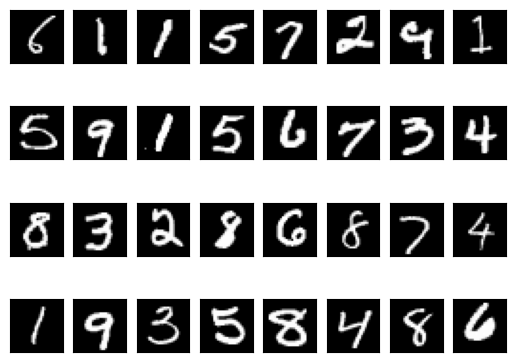

In [44]:
for (batch_idx, target_tuple) in enumerate(train_dataloader):
    print(target_tuple[0].shape)

    for i in range(32):
        plt.subplot(4, 8, i + 1)
        plt.imshow(target_tuple[0][i], cmap = 'gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    break

In [46]:
use_cuda = torch.cuda.is_available()  
best_loss = float('inf')

model = SimpleModel(dropout_rate = 0.5)

optimizer = torch.optim.Adadelta(model.parameters())

if use_cuda:
    model = torch.nn.parallel.DataParallel(model.cuda()) 
    torch.backends.cudnn.benchmark = True

In [48]:
def train(epoch):
    print('\n ############################# Train phase, Epoch: {} #############################'.format(epoch))
    model.train()
    train_loss = 0

    print('\nLearning rate at this epoch is: ', optimizer.param_groups[0]['lr'], '\n')

    for (batch_idx, target_tuple) in enumerate(train_dataloader):
        if use_cuda:
            target_tuple = [target_tensor.cuda(non_blocking=True) for target_tensor in target_tuple]

        images, labels = target_tuple
        labels = torch.tensor(labels, dtype = torch.long)

        optimizer.zero_grad()  
        output_tuple = model(images)

        loss = F.nll_loss(output_tuple, labels).cuda()
        loss.backward()  
        optimizer.step()

        train_loss += loss.item()
        print('########################### Epoch:', epoch, ', --  batch:',  batch_idx, '/', len(train_dataloader), ',   ',
              'Train loss: %.3f, accumulated average loss: %.3f ##############################' % (loss.item(), train_loss / (batch_idx + 1)))

    global best_loss
    train_loss /= len(train_dataloader)
    if train_loss < best_loss:
      noti = 'best_'
      best_loss = train_loss
    else:
      noti = ''
    print('saving...')
    state = {
      'weights': model.module.state_dict(),
      'optimizer_weight': optimizer.state_dict(),
      'train_loss': train_loss,
      'epoch': epoch,
    }
    os.makedirs('checkpoints', exist_ok=True)
    torch.save(state, 'checkpoints/model_' + noti + str(epoch) + '_epoch.pth')

In [50]:
def test(epoch):
    print('\n ############################# Test phase, Epoch: {} #############################'.format(epoch))
    
    model.eval()
    
    with torch.no_grad():
        test_loss = 0

        for (batch_idx, target_tuple) in enumerate(test_dataloader):
            if use_cuda:
                target_tuple = [target_tensor.cuda(non_blocking=True) for target_tensor in target_tuple]

            images, labels = target_tuple
            labels = torch.tensor(labels,dtype = torch.long)
            output_tuple = model(images)

            loss = F.nll_loss(output_tuple, labels).cuda()

            test_loss += loss.item()
            print('########################### Epoch:', epoch, ', --  batch:',  batch_idx, '/', len(test_dataloader), ',   ',
                  'Test loss: %.3f, accumulated average loss: %.3f ##############################' % (loss.item(), test_loss / (batch_idx + 1)))